## Agreements - All Articles

Vamos a ver los resultados del primer batch, que está etiquetado completo por dvalado y casi completo por gdamill

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import django
from tqdm.auto import tqdm

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

sys.path.append("..")
os.environ['DJANGO_SETTINGS_MODULE'] = 'news_labelling.settings'
django.setup()

from api.models import Comment, ArticleLabel, CommentLabel, Article, Batch
from django.contrib.auth.models import User

Primero, veamos qué usuarios etiquetaron más de 4 artículos...

In [2]:
from django.db.models import Count
from api.metrics import AgreementCalculator

articles = Article.objects.exclude(batch__name__in=["demo", "training"])

users = [u for u in User.objects.filter(username__in=[
    "asilva", 
    "fdesanctis", 
    "gdamill", 
    "dvalado", 
    "gclerici",
    "lprats",
])]

calculator = AgreementCalculator(articles=articles, users=users)



¿Cuántos etiquetamos todes?

In [3]:
import pandas as pd

pd.options.display.max_columns = 40

calculator.get_labelled_articles()

,"Alberto Fernández: “No discutamos más, el daño lo hizo la pandemia, no la cuarentena”","Oscar González Oro, harto de la cuarentena: ""El día que se pueda me voy a Uruguay""",Ginés González García sobre los médicos cubanos: “Tenemos enorme necesidad de recursos y no veo por qué discriminar según el lugar de procedencia”,El ministro de Salud bonaerense volvió a culpar a la Ciudad por el aumento de casos de coronavirus: “Los contagios van de CABA a la provincia”,El Gobierno analiza extender la cuarentena hasta el 8 de junio,La OMS pidió ahora evitar las cuarentenas como método principal para controlar el avance del coronavirus,Vecinos de la Villa 31 denuncian que llevan más de cuatro días sin agua y con cortes de luz: “En pandemia la necesitamos más que nunca”,Mayra Mendoza criticó el banderazo contra el Gobierno: “No tiene sentido y es antidemocrático”,Se separaron Marcelo Tinelli y Guillermina Valdés,Por qué Paraguay es el país que tuvo el menor impacto del coronavirus en Sudamérica,"Coronavirus en Argentina: volvían de Brasil y cambiaron los carteles de los micros para evitar la cuarentena, pero fueron detenidos","Coronavirus. Pedro Cahn: ""Me cuesta entender la militancia anticuarentena, que alguien me explique cuál es la alternativa""","Matías Lammens: ""Los tripulantes de Aerolíneas Argentinas están haciendo patria""",Alberto Fernández se enfrentó con Cristina Pérez y la mandó a leer la Constitución Nacional,"Es enfermera, atiende a pacientes con coronavirus y sus vecinos mataron a sus mascotas para que deje el barrio","El mensaje de Florencia Kirchner antes de volver a la Argentina: ""Tengo lágrimas negras""",Oscar González Oro ya está instalado en el Uruguay: “Recuperé mi libertad”,"Quedó varado en Bariloche por la cuarentena, una familia lo alojó y violó a una nena de 11 años",Juan Grabois: “Hay que aplicar la autoridad sobre las personas que se manifestaron”,Coronavirus en la Argentina: Alberto Fernández analiza extender la cuarentena obligatoria hasta el 8 de junio,...,Elisa Carrió: “La situación del país y del peso es de una gravedad inusitada; estamos sin moneda nacional”,"Laura Azcurra: “Es contradictorio que los actores estamos sin trabajar, pero la gente está en su casa viendo películas y series que hemos hecho nosotros”","Mauricio Macri rompió el silencio: ""Vienen desplegando un ataque sistemático a la Constitución""",Se entregó la penitenciaria acusada de matar a tiros a un preso en el motín de Florencio Varela,La pregunta billonaria: ¿quién debería pagar el costo de la pandemia?,"José Luis Chilavert fustigó a Diego Maradona por su relación con Nicolás Maduro, Hugo Chávez y Fidel Castro","“Me quiero matar”, la carta del preso que quedó parapléjico tras el motín en Devoto",Alertan por nuevo virus con potencial de pandemia,Tucumán: una madre tuvo que esconder a su hija porque su vecino violador con prisión domiciliaria la acosa constantemente,El polémico cortejo fúnebre de los barras de Quilmes para despedir al ladrón baleado por el jubilado,Nuevo banderazo en contra del Gobierno nacional en distintas ciudades del país,El polémico mensaje de Cinthia Fernández sobre la muerte de un delincuente en un intento de robo,La nueva vida de Victoria Vannucci en San Diego: abrió una cadena de restaurantes sustentables y se convirtió en proteccionista de animales,Le rompieron un silobolsa y alguien le dejó escrito: La Cámpora,"Le sacó el arma al ladrón que lo asaltó, lo corrió y lo mató de un disparo: quedó detenido","Robó a una embarazada, los vecinos lo lincharon y pidió clemencia: “Perdón, tengo dos pibes”",Escándalo en el Congreso: escena sexual del diputado kirchnerista Juan Emilio Ameri en plena sesión virtual,"En Tucumán, la nueva ley antimotochorros introduce con un cambio clave: estará prohibido que dos adultos viajen en una moto",Le iniciaron una causa judicial a la mujer que fue grabada maltratando a su perro,Juan Grabois defendió las tomas de terrenos y cuestionó a los funcionarios que las consideraron un delit

## Agreements sobre odio

Ahora usamos sólo Alpha que da casi igual que Fleiss

In [4]:
import krippendorff

alpha, support = calculator.get_agreement("hate")

print(f"Alpha HATE para {' - '.join(calculator.usernames)}: {alpha:.3f} (soporte = {support})")


Alpha HATE para asilva - dvalado - fdesanctis - gclerici - gdamill - lprats: 0.558 (soporte = 3793)


In [5]:
print("Cantidad de mensajes etiquetados como odiosos")

calculator.get_bias_towards("hate")

Cantidad de mensajes etiquetados como odiosos


etiquetador
asilva        0.120180
dvalado       0.294483
fdesanctis    0.216022
gclerici      0.100673
gdamill       0.177103
lprats        0.110082
dtype: float64

In [27]:
usernames = sorted([u.username for u in users])

agreements = pd.DataFrame(columns=usernames)

for i, u1 in enumerate(users):
    agreements.loc[u1.username, u1.username] = 1.0
    for j in range(i+1, len(users)):
        u2 = users[j]
        alpha, _ = calculator.get_agreement("hate", users=[u1.username, u2.username])
        agreements.loc[u1.username, u2.username] = alpha
        agreements.loc[u2.username, u1.username] = alpha

In [35]:
agreements = agreements.astype(float)

<AxesSubplot:>

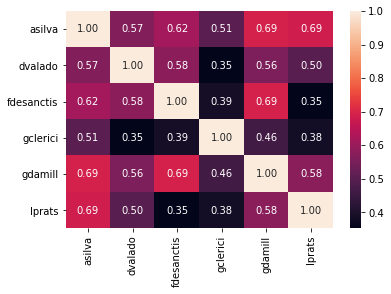

In [38]:
import seaborn as sns

sns.heatmap(agreements, fmt=".2f", annot=True)

In [17]:
agreements.mean(axis=1)

asilva        0.613164
dvalado       0.511231
fdesanctis    0.525718
gclerici      0.419189
gdamill       0.596165
lprats        0.499466
dtype: float64

Veamos qué porcentaje de comentarios etiquetan como odiosos

In [24]:
calculator.get_bias_towards("hate")

etiquetador
asilva        0.120180
dvalado       0.294483
fdesanctis    0.216022
gclerici      0.100673
gdamill       0.177103
lprats        0.110082
dtype: float64

¿Cómo cambia el agreement sacando a cada uno de los anotadores?

In [21]:
for u in users:
    users_without = [username for username in usernames if username != u.username]
    alpha, _ = calculator.get_agreement("hate", users=users_without)
    print(f"- a {u.username:<12} ---> {alpha:.3f}")

- a asilva       ---> 0.521
- a dvalado      ---> 0.584
- a fdesanctis   ---> 0.548
- a gclerici     ---> 0.611
- a gdamill      ---> 0.515
- a lprats       ---> 0.562


In [23]:
krippendorff.alpha?

Signature:
krippendorff.alpha(
    reliability_data: Union[Iterable[Any], NoneType] = None,
    value_counts: Union[numpy.ndarray, NoneType] = None,
    value_domain: Union[Sequence[Any], NoneType] = None,
    level_of_measurement: Union[str, Callable[..., Any]] = 'interval',
    dtype: Any = <class 'numpy.float64'>,
) -> float
Docstring:
Compute Krippendorff's alpha.

See https://en.wikipedia.org/wiki/Krippendorff%27s_alpha for more information.

Parameters
----------
reliability_data : array_like, with shape (M, N)
    Reliability data matrix which has the rate the i coder gave to the j unit, where M is the number of raters
    and N is the unit count.
    Missing rates are represented with `np.nan`.
    If it's provided then `value_counts` must not be provided.

value_counts : ndarray, with shape (N, V)
    Number of coders that assigned a certain value to a determined unit, where N is the number of units
    and V is the value count.
    If it's provided then `reliability_data` mus